In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns


In [38]:
data= r"C:\Users\med\Documents\GitHub\flim_granules_analysis\notebooks\master_table.csv"

df= pd.read_csv(data)#,sep=";")

In [39]:
df

,Unnamed: 0,Label,Area,intensity_mean_fluor,mean_chi2,mean_tau,min_fluor,min_chi2,min_tau,STD_fluor,STD_chi2,STD_tau,File Name,cells,transfection,treatment,Date,selected_analysis
0,1,2,103.0,341.097087,102.349515,1003.407767,242.0,70.0,483.0,55.201927,12.317569,216.245969,1f,cl1,pcdna,cq,2024-09-11,analyze_single_fitted_channel
1,2,3,53.0,436.150943,103.773585,1097.433962,365.0,69.0,672.0,26.529724,11.442459,224.308792,1f,cl1,pcdna,cq,2024-09-11,analyze_single_fitted_channel
2,3,4,105.0,410.723810,102.095238,1019.704762,374.0,78.0,620.0,22.639828,12.538340,213.571263,1f,cl1,pcdna,cq,2024-09-11,analyze_single_fitted_channel
3,10,11,71.0,309.183099,96.352113,953.323944,272.0,62.0,610.0,13.885153,12.677027,223.152810,1f,cl1,pcdna,cq,2024-09-11,analyze_single_fitted_channel
4,11,12,54.0,331.055556,99.092593,1067.444444,264.0,67.0,642.0,47.979709,11.895017,236.747456,1f,cl1,pcdna,cq,2024-09-11,analyze_single_fitted_channel
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13837,160,161,49.0,486.653061,105.979592,982.326531,400.0,83.0,713.0,32.254442,13.704594,171.437070,5f,cl2,pcdna,imi,2024-09-15,analyze_single_fitted_channel
13838,161,162,85.0,547.164706,112.105882,1078.564706,473.0,86.0,607.0,39.157554,12.415383,191.441064,5f,cl2,pcdna,imi,2024-09-15,analyze_single_fitted_channel
13839,162,163,210.0,552.480952,109.971429,957.038095,272.0,76.0,561.0,133.342924,13.757739,195.689765,5f,cl2,pcdna,imi,2024-09-15,analyze_single_fitted_channel
13840,165,166,63.0,332.698413,98.761905,880.190476,253.0,76.0,369.0,38.486293,11.316113,189.377247,5f,cl2,pcdna,imi,2024-09-15,analyze_single_fitted_channel


In [50]:
import pandas as pd

def sample_data_balanced_with_logging(data, n=100):
    """
    Sample `n` instances for each combination of `transfection`, `cells`, and `treatment`,
    ensuring that the `Date` distribution is approximately balanced. Logs cases where fewer
    than `n` instances are available.
    
    Args:
    - data: DataFrame containing the data to sample from.
    - n: Number of instances to sample for each combination of `transfection`, `cells`, and `treatment`.
    
    Returns:
    - A tuple: (sampled_data, shortfall_log)
      sampled_data: A DataFrame with the sampled data.
      shortfall_log: A DataFrame logging groups where fewer than `n` instances were available.
    """
    # Group the data by transfection, cells, and treatment (ignoring Date for now)
    grouped_data = data.groupby(['transfection', 'cells', 'treatment'])

    # Initialize an empty DataFrame to store sampled data
    sampled_data = pd.DataFrame()

    # Initialize a list to log groups where fewer than `n` instances are available
    shortfall_log = []

    # Iterate over each group
    for group_name, group_df in grouped_data:
        total_available = len(group_df)

        # If the group has fewer than `n` instances, log the shortfall
        if total_available < n:
            shortfall_log.append({
                'group': group_name,
                'available_instances': total_available,
                'requested_samples': n
            })
            # Sample all available instances
            sampled_group_df = group_df
        else:
            # Shuffle the group_df to ensure randomness
            group_df = group_df.sample(frac=1, random_state=42)

            # Get the unique dates in this group
            unique_dates = group_df['Date'].unique()

            # If there's only one date, sample directly
            if len(unique_dates) == 1:
                sampled_group_df = group_df.sample(n=n, replace=False)
            else:
                # Calculate how many samples we want per date using proportional distribution
                date_counts = group_df['Date'].value_counts()
                samples_per_date = (date_counts / date_counts.sum() * n).astype(int)

                # Initialize the sampled group DataFrame
                sampled_group_df = pd.DataFrame()

                # Take samples from each date based on the calculated proportional samples
                for date, count in samples_per_date.items():
                    available_from_date = len(group_df[group_df['Date'] == date])
                    samples_to_take = min(count, available_from_date)
                    sampled_group_df = pd.concat([
                        sampled_group_df,
                        group_df[group_df['Date'] == date].sample(samples_to_take, replace=False)
                    ])

                # Adjust to exactly `n` samples by adding/removing random samples if necessary
                if len(sampled_group_df) < n:
                    additional_samples = group_df[~group_df.index.isin(sampled_group_df.index)].sample(n - len(sampled_group_df), replace=False)
                    sampled_group_df = pd.concat([sampled_group_df, additional_samples])
                elif len(sampled_group_df) > n:
                    sampled_group_df = sampled_group_df.sample(n=n, replace=False)

        # Append the sampled data to the final DataFrame
        sampled_data = pd.concat([sampled_data, sampled_group_df], ignore_index=True)

    # Convert the shortfall log to a DataFrame for better readability
    shortfall_log_df = pd.DataFrame(shortfall_log)
# Inspect the shortfall log
    if not shortfall_log_df.empty:
        print("Groups with fewer available instances than requested:")
        print(shortfall_log_df)
    else:
        print("No shortfalls found!")
    return sampled_data, shortfall_log_df






In [54]:
# Usage example:
sampled_data, shortfall_log_df = sample_data_balanced_with_logging(df, n=100)




No shortfalls found!


c:\Users\med\mambaforge\envs\napari-flim-phasor-env\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


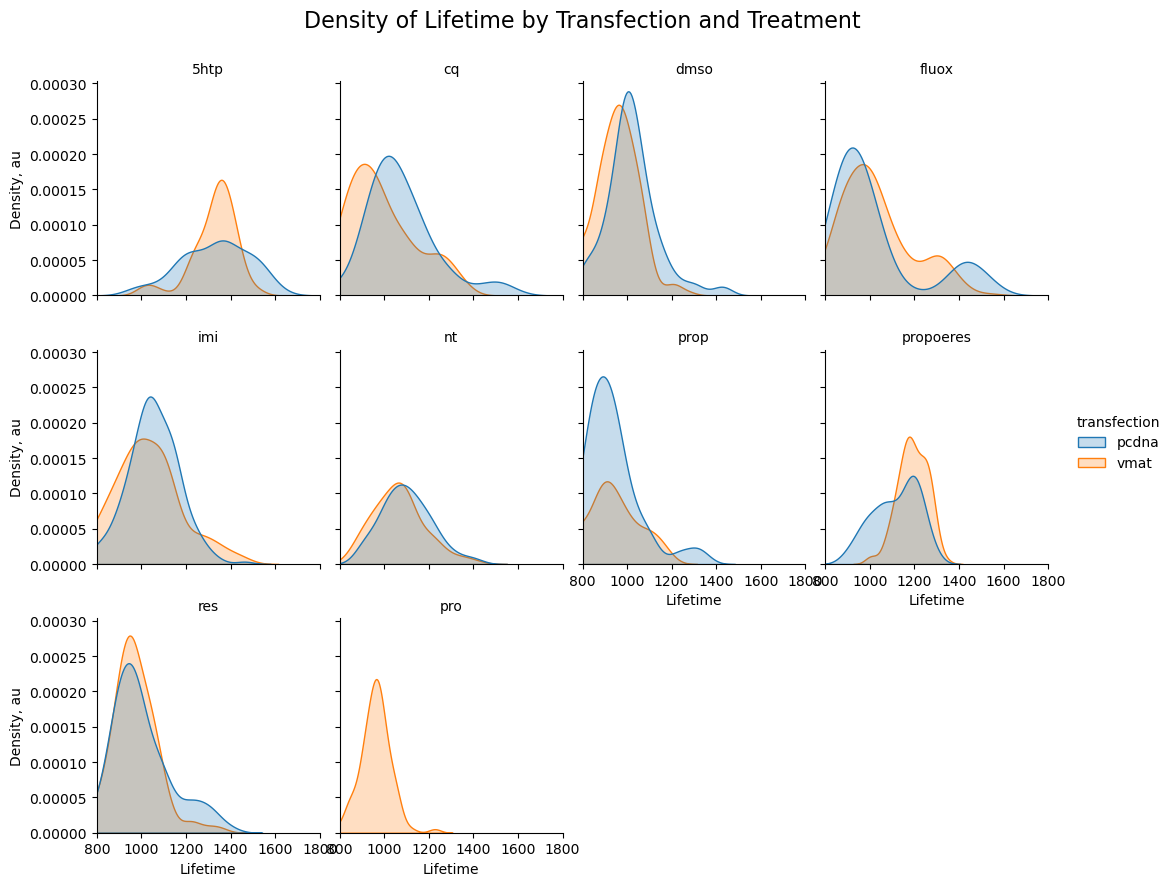

In [52]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Create the plot with facets, wrapping the columns (treatments) into 2 rows
h = sns.displot(
    sampled_data, hue="transfection", x="mean_tau", col="treatment",
    kind="kde", height=3, aspect=0.9, fill=True, col_wrap=4  # Adjust col_wrap to wrap facets
)

# Set axis labels
h.set_axis_labels("Lifetime", "Density, au")

# Set individual facet titles (one for each treatment)
h.set_titles("{col_name}")

# Set x-axis limits
h.set(xlim=(800, 1800))

# Adjust the spacing between the facets
h.fig.subplots_adjust(top=0.9)  # Adjust the top space to make room for the main title

# Add a main title to the entire plot
plt.suptitle("Density of Lifetime by Transfection and Treatment", fontsize=16)

# Show the plot
plt.show()


c:\Users\med\mambaforge\envs\napari-flim-phasor-env\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


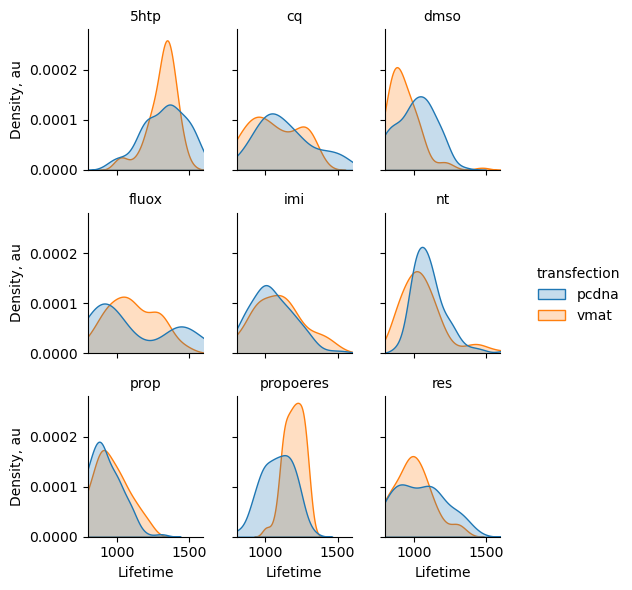

c:\Users\med\mambaforge\envs\napari-flim-phasor-env\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


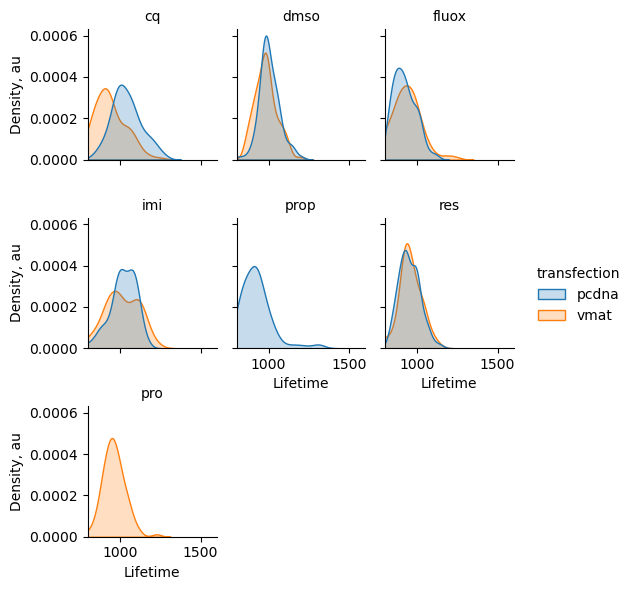

In [64]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Filter for two different cell types
sampled_data_1 = sampled_data[sampled_data['cells'] == 'cl1']
sampled_data_2 = sampled_data[sampled_data['cells'] == 'cl2']

# Check if there's data in the filtered datasets
if not sampled_data_1.empty:
    # Plot for the first subset (e.g., CellType1)
    h1 = sns.displot(
        sampled_data_1, hue="transfection", x="mean_tau", col="treatment",
        kind="kde", height=2, aspect=0.9, fill=True, col_wrap=3
    )
    # Set axis labels and titles for the first plot
    h1.set_axis_labels("Lifetime", "Density, au")
    h1.set_titles("{col_name}")
    h1.set(xlim=(800, 1600))
    #plt.suptitle("Density of Lifetime by Transfection and Treatment for CellType1", fontsize=16)
    plt.show()
else:
    print("No data available for CellType1")

# Check if there's data in the second filtered dataset
if not sampled_data_2.empty:
    # Plot for the second subset (e.g., CellType2)
    h2 = sns.displot(
        sampled_data_2, hue="transfection", x="mean_tau", col="treatment",
        kind="kde", height=2, aspect=0.9, fill=True, col_wrap=3
    )
    # Set axis labels and titles for the second plot
    h2.set_axis_labels("Lifetime", "Density, au")
    h2.set_titles("{col_name}")
    h2.set(xlim=(800, 1600))
    #plt.suptitle("Density of Lifetime by Transfection and Treatment for CellType2", fontsize=16)
    plt.show()
else:
    print("No data available for CellType2")


Here end 

C:\Users\med\AppData\Local\Temp\ipykernel_12700\2963279327.py:14: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(treated_data['mean_tau'], label='Treated', shade=True)
C:\Users\med\AppData\Local\Temp\ipykernel_12700\2963279327.py:15: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(dmso_data['mean_tau'], label='dmso', shade=True)


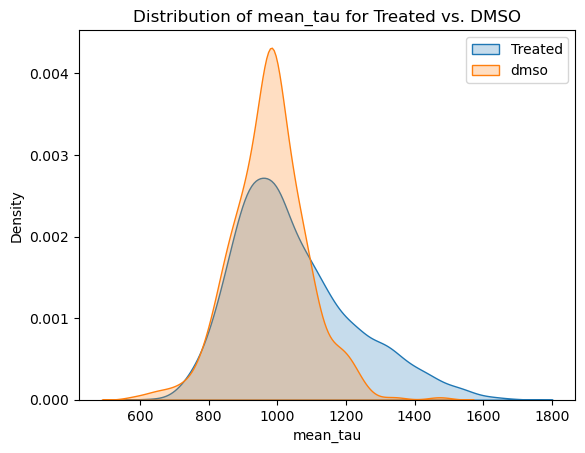

Treated group normality p-value: 1.9703988964311594e-27
DMSO group normality p-value: 0.000245130795519799


In [66]:
import pandas as pd
import seaborn as sns
from scipy import stats

# Assume `treatment` column has 'DMSO' for DMSO treatment and other values for treated conditions

# Filter the treated group (any treatment except DMSO)
treated_data = sampled_data[sampled_data['treatment'] != 'dmso']

# Filter the DMSO group
dmso_data = sampled_data[sampled_data['treatment'] == 'dmso']

# Check the distributions (for example, using `mean_tau`)
sns.kdeplot(treated_data['mean_tau'], label='Treated', shade=True)
sns.kdeplot(dmso_data['mean_tau'], label='dmso', shade=True)
plt.xlabel('mean_tau')
plt.ylabel('Density')
plt.legend()
plt.title("Distribution of mean_tau for Treated vs. DMSO")
plt.show()
# Shapiro-Wilk test for normality
stat, p_value_treated = stats.shapiro(treated_data['mean_tau'])
stat, p_value_dmso = stats.shapiro(dmso_data['mean_tau'])

print(f"Treated group normality p-value: {p_value_treated}")
print(f"DMSO group normality p-value: {p_value_dmso}")


In [76]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def bootstrap_confidence_intervals(data, n_iterations=1000, sample_size=None, statistic='mean'):
    """
    Bootstrap confidence intervals for a given statistic (e.g., mean, std, or percentile).
    
    Args:
    - data: Array or list of data to bootstrap.
    - n_iterations: Number of bootstrap iterations.
    - sample_size: Size of each sample (default is the length of the original data).
    - statistic: Statistic to compute ('mean', 'std', 'percentile_5', 'percentile_95', etc.).
    
    Returns:
    - A list of bootstrapped statistics.
    """
    if sample_size is None:
        sample_size = len(data)
        
    stats = []
    
    for _ in range(n_iterations):
        sample = np.random.choice(data, size=sample_size, replace=True)
        
        if statistic == 'mean':
            stats.append(np.mean(sample))
        elif statistic == 'std':
            stats.append(np.std(sample))
        elif 'percentile' in statistic:
            percentile = int(statistic.split('_')[1])
            stats.append(np.percentile(sample, percentile))
        else:
            raise ValueError("Statistic not supported.")
    
    return stats

# Example of using bootstrapping to compare treatments vs DMSO
def compare_distributions_bootstrap(data, treatment_col='treatment', cell_col='cells', target_col='mean_tau', transfection_col='transfection'):
    """
    Perform bootstrapping to analyze differences in distributions (not just mean) between treatments and DMSO.
    
    Args:
    - data: DataFrame containing the dataset.
    - treatment_col: Column name for treatment.
    - cell_col: Column name for cell types.
    - transfection_col: Column name for transfection groups.
    - target_col: Column name for the data of interest (e.g., mean_tau).
    
    Returns:
    - A DataFrame with bootstrapped confidence intervals for different statistics.
    """
    results = []

    # Get the unique cell types
    cell_types = data[cell_col].unique()

    for cell in cell_types:
        # Filter the data by cell type
        cell_data = data[data[cell_col] == cell]
        
        # Get the DMSO group
        dmso_group = cell_data[cell_data[treatment_col] == 'dmso'][target_col]

        # Get the unique treatments (excluding DMSO)
        treatments = cell_data[cell_data[treatment_col] != 'dmso'][treatment_col].unique()

        for treatment in treatments:
            treatment_group = cell_data[cell_data[treatment_col] == treatment][target_col]

            # Bootstrap confidence intervals for mean, std, and percentiles
            treatment_bootstrap_mean = bootstrap_confidence_intervals(treatment_group, statistic='mean')
            treatment_bootstrap_std = bootstrap_confidence_intervals(treatment_group, statistic='std')
            treatment_bootstrap_percentile_5 = bootstrap_confidence_intervals(treatment_group, statistic='percentile_5')
            treatment_bootstrap_percentile_95 = bootstrap_confidence_intervals(treatment_group, statistic='percentile_95')
            
            dmso_bootstrap_mean = bootstrap_confidence_intervals(dmso_group, statistic='mean')
            dmso_bootstrap_std = bootstrap_confidence_intervals(dmso_group, statistic='std')
            dmso_bootstrap_percentile_5 = bootstrap_confidence_intervals(dmso_group, statistic='percentile_5')
            dmso_bootstrap_percentile_95 = bootstrap_confidence_intervals(dmso_group, statistic='percentile_95')

            results.append({
                'cell_type': cell,
                'treatment': treatment,
                'treatment_bootstrap_mean': np.mean(treatment_bootstrap_mean),
                'treatment_bootstrap_std': np.mean(treatment_bootstrap_std),
                'treatment_percentile_5': np.mean(treatment_bootstrap_percentile_5),
                'treatment_percentile_95': np.mean(treatment_bootstrap_percentile_95),
                'dmso_bootstrap_mean': np.mean(dmso_bootstrap_mean),
                'dmso_bootstrap_std': np.mean(dmso_bootstrap_std),
                'dmso_percentile_5': np.mean(dmso_bootstrap_percentile_5),
                'dmso_percentile_95': np.mean(dmso_bootstrap_percentile_95)
            })
    
    return pd.DataFrame(results)

# Run the bootstrapping comparison
bootstrap_results = compare_distributions_bootstrap(sampled_data)

# Display the results
print(bootstrap_results)


   cell_type  treatment  treatment_bootstrap_mean  treatment_bootstrap_std  \
0        cl1       5htp               1322.129043               128.336474   
1        cl1         cq               1091.793826               192.065963   
2        cl1      fluox               1105.598515               226.139234   
3        cl1        imi               1064.522883               168.347590   
4        cl1         nt               1084.194001               142.056826   
5        cl1       prop                936.452830               118.292145   
6        cl1  propoeres               1140.345377               107.628592   
7        cl1        res               1015.037939               157.256241   
8        cl2         cq                986.754410               107.928543   
9        cl2      fluox                925.185757                80.595025   
10       cl2        imi               1014.687421                90.731340   
11       cl2       prop                922.890919               

In [79]:
from scipy.stats import ks_2samp

def ks_test_distributions(data, treatment_col='treatment', cell_col='cells', target_col='mean_tau'):
    """
    Perform the Kolmogorov-Smirnov test to compare distribution shapes between treatments and DMSO.
    
    Args:
    - data: DataFrame containing the dataset.
    
    Returns:
    - A DataFrame with KS test results for each treatment vs DMSO.
    """
    results = []
    
    cell_types = data[cell_col].unique()

    for cell in cell_types:
        cell_data = data[data[cell_col] == cell]
        dmso_group = cell_data[cell_data[treatment_col] == 'dmso'][target_col]
        treatments = cell_data[cell_data[treatment_col] != 'dmso'][treatment_col].unique()

        for treatment in treatments:
            treatment_group = cell_data[cell_data[treatment_col] == treatment][target_col]
            ks_stat, p_value = ks_2samp(treatment_group, dmso_group)
            results.append({
                'cell_type': cell,
                'treatment': treatment,
                'ks_stat': ks_stat,
                'p_value': p_value
            })
    
    return pd.DataFrame(results)

# Run the KS test
ks_test_results = ks_test_distributions(sampled_data)

# Display KS test results
print(ks_test_results)

# Filter for significant p-values (e.g., p-value < 0.05)
significant_ks_results = ks_test_results[ks_test_results['p_value'] < 0.05]
print("Significant KS test results:")
print(significant_ks_results)


   cell_type  treatment  ks_stat       p_value
0        cl1       5htp    0.815  4.783211e-67
1        cl1         cq    0.305  1.294088e-08
2        cl1      fluox    0.290  8.114130e-08
3        cl1        imi    0.265  1.392105e-06
4        cl1         nt    0.390  5.867302e-14
5        cl1       prop    0.120  1.122836e-01
6        cl1  propoeres    0.560  3.190552e-29
7        cl1        res    0.170  6.094418e-03
8        cl2         cq    0.195  9.668691e-04
9        cl2      fluox    0.420  3.432079e-16
10       cl2        imi    0.235  2.960783e-05
11       cl2       prop    0.505  6.514965e-16
12       cl2        res    0.310  6.865582e-09
13       cl2        pro    0.300  9.908152e-06
Significant KS test results:
   cell_type  treatment  ks_stat       p_value
0        cl1       5htp    0.815  4.783211e-67
1        cl1         cq    0.305  1.294088e-08
2        cl1      fluox    0.290  8.114130e-08
3        cl1        imi    0.265  1.392105e-06
4        cl1         nt    0.39

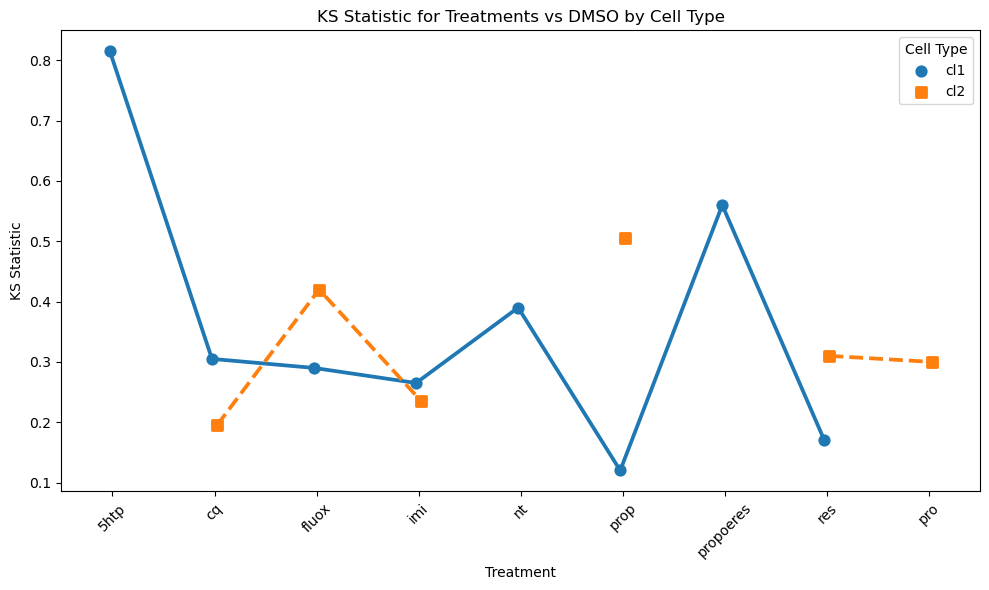

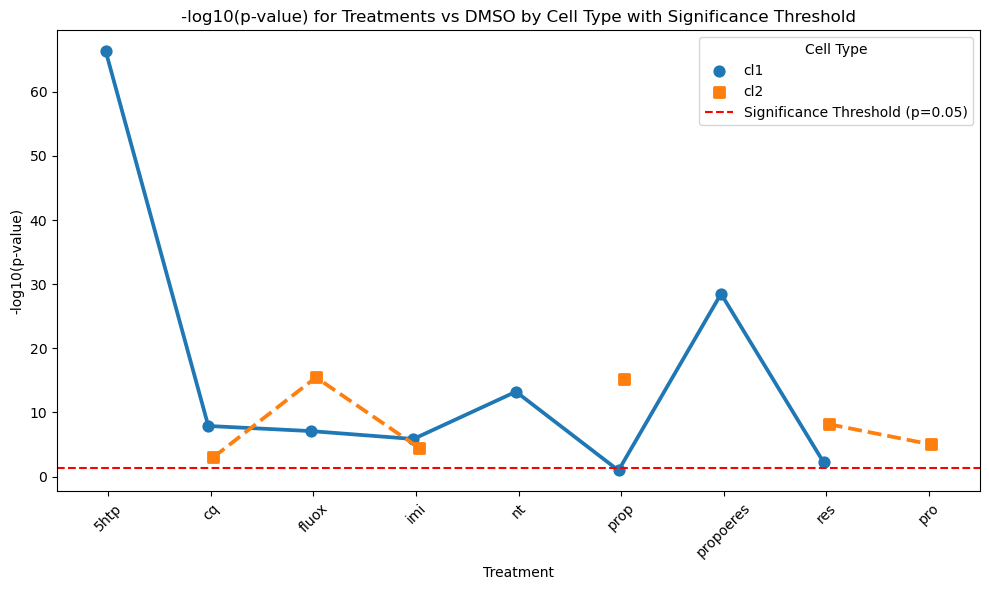

In [95]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Convert p-values to -log10 for better visualization (optional)
ks_test_results['log_p_value'] = -np.log10(ks_test_results['p_value'])

# Create a point plot for KS statistic
plt.figure(figsize=(10, 6))
sns.pointplot(data=ks_test_results, x='treatment', y='ks_stat', hue='cell_type', dodge=True, markers=['o', 's'], linestyles=['-', '--'])
plt.title('KS Statistic for Treatments vs DMSO by Cell Type')
plt.ylabel('KS Statistic')
plt.xlabel('Treatment')
plt.xticks(rotation=45)
plt.legend(title='Cell Type')
plt.tight_layout()
plt.show()

# Create a point plot for log(p-value) with a significance threshold
plt.figure(figsize=(10, 6))
sns.pointplot(data=ks_test_results, x='treatment', y='log_p_value', hue='cell_type', dodge=True, markers=['o', 's'], linestyles=['-', '--'])

# Add a horizontal line for the significance threshold at -log10(0.05)
plt.axhline(y=-np.log10(0.05), color='red', linestyle='--', label='Significance Threshold (p=0.05)')

# Plot customization
plt.title('-log10(p-value) for Treatments vs DMSO by Cell Type with Significance Threshold')
plt.ylabel('-log10(p-value)')
plt.xlabel('Treatment')
plt.xticks(rotation=45)
plt.legend(title='Cell Type')
plt.tight_layout()
plt.show()
